In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

In [ ]:
batch_size = 4096

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
dataset = datasets.MNIST(root="data/", download=True, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transform)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True
)

In [ ]:
class FlatModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        return x

In [ ]:
class DenseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.stack(x)
        return x

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )

    def forward(self, xb):
        out = self.stack(xb)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
model = CNNModel().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

test_losses = []
losses = []


def test():
    with torch.no_grad():
        test_loss = 0
        for i, (images, labels) in enumerate(test_dataloader):
            out = model(images.to(device))
            test_loss += F.cross_entropy(out, labels.to(device), reduction="sum").item()
        test_loss /= len(test_dataset)

    return test_loss


epochs = 30

logging_interval = 10
def train(epochs):
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(dataloader):
            out = model(images.to(device))
            loss = crit(out, labels.to(device))
            loss.backward()
            optim.step()
            optim.zero_grad()

            if i % logging_interval == 0:
                losses.append(loss.item())
                test_losses.append(test())

        print(f"Epoch: {epoch}, Loss: {loss.item()}")


train(epochs)

Running on cuda
Epoch: 0, Loss: 0.5842329263687134
Epoch: 1, Loss: 0.31735238432884216
Epoch: 2, Loss: 0.20332719385623932
Epoch: 3, Loss: 0.1663065403699875
Epoch: 4, Loss: 0.0946827083826065
Epoch: 5, Loss: 0.08666404336690903
Epoch: 6, Loss: 0.07478737831115723
Epoch: 7, Loss: 0.07801534980535507
Epoch: 8, Loss: 0.04422307014465332
Epoch: 9, Loss: 0.0466347262263298
Epoch: 10, Loss: 0.051361944526433945
Epoch: 11, Loss: 0.03654162958264351
Epoch: 12, Loss: 0.0375162698328495
Epoch: 13, Loss: 0.0329141728579998
Epoch: 14, Loss: 0.03224073722958565
Epoch: 15, Loss: 0.027624666690826416
Epoch: 16, Loss: 0.02481677010655403
Epoch: 17, Loss: 0.02339525893330574
Epoch: 18, Loss: 0.029456987977027893
Epoch: 19, Loss: 0.016583142802119255
Epoch: 20, Loss: 0.018850218504667282
Epoch: 21, Loss: 0.022869357839226723
Epoch: 22, Loss: 0.01504087820649147
Epoch: 23, Loss: 0.013008994981646538
Epoch: 24, Loss: 0.01221861969679594
Epoch: 25, Loss: 0.01253899373114109
Epoch: 26, Loss: 0.014221171848

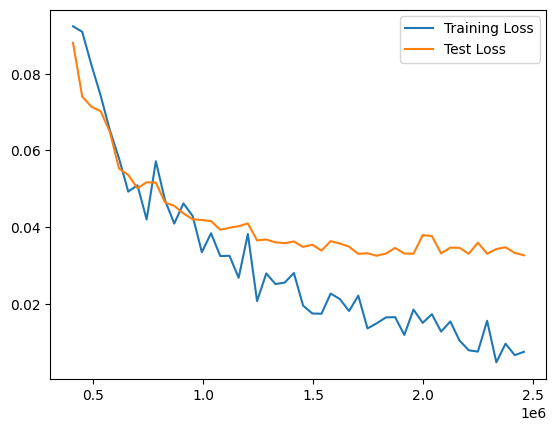

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

o = 10
d = len(losses)

plt.plot(np.linspace(o * logging_interval * batch_size, d * logging_interval * batch_size, d - o), losses[o:d])
plt.plot(np.linspace(o * logging_interval * batch_size, d * logging_interval * batch_size, d - o), test_losses[o:d])
plt.legend(['Training Loss', 'Test Loss'])
# plt.plot(list(map(lambda x: np.log(x), losses)), color='#9fbd59')

In [ ]:
train(10)

Epoch: 0, Loss: 0.028171157464385033
Epoch: 1, Loss: 0.02036811225116253
Epoch: 2, Loss: 0.014403652399778366
Epoch: 3, Loss: 0.018588023260235786
Epoch: 4, Loss: 0.014841989614069462
Epoch: 5, Loss: 0.012402626685798168
Epoch: 6, Loss: 0.014294873923063278
Epoch: 7, Loss: 0.008851828053593636
Epoch: 8, Loss: 0.01095210574567318
Epoch: 9, Loss: 0.011965421959757805


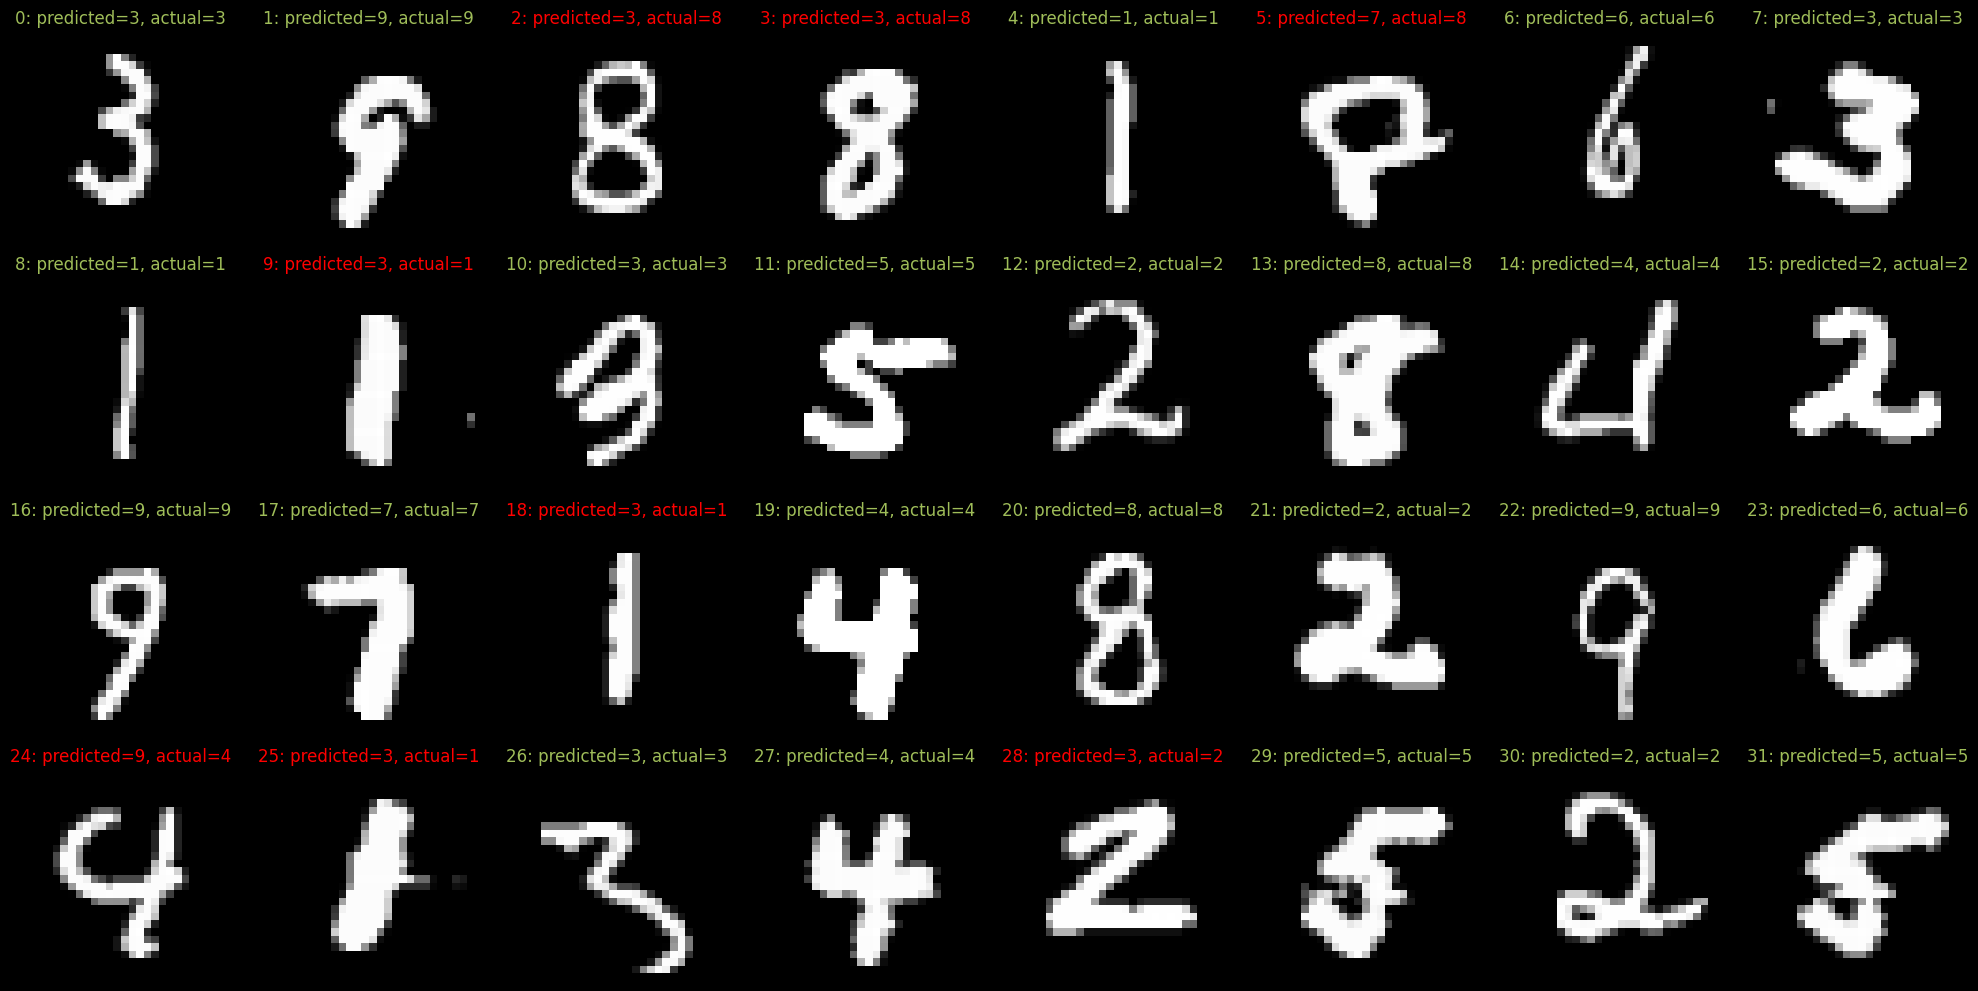

In [ ]:
fig, axs = plt.subplots(4, 8, figsize=(20, 10))
axs = axs.flatten()

offset = 1234

images = dataset.data[offset : 32 + offset].float().unsqueeze(1)
labels = dataset.targets[offset : 32 + offset]

with torch.no_grad():
    out = model(images.to(device))

for i in range(32):
    predicted = out[i].argmax().item()
    actual = labels[i].item()
    axs[i].imshow(images[i].reshape(28, 28), cmap="gray")
    if predicted != actual:
        axs[i].set_title(f"{i}: {predicted=}, {actual=}", color="red")
    else:
        axs[i].set_title(f"{i}: {predicted=}, {actual=}", color="#9fbd59")
    axs[i].axis("off")

plt.gcf().patch.set_facecolor('black')
plt.tight_layout()
plt.show()

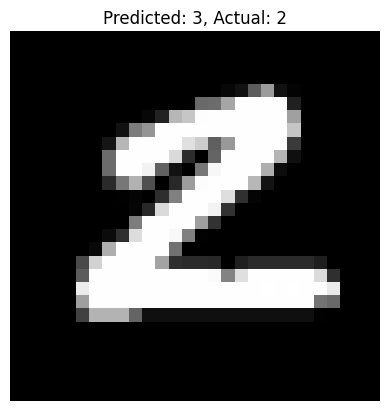

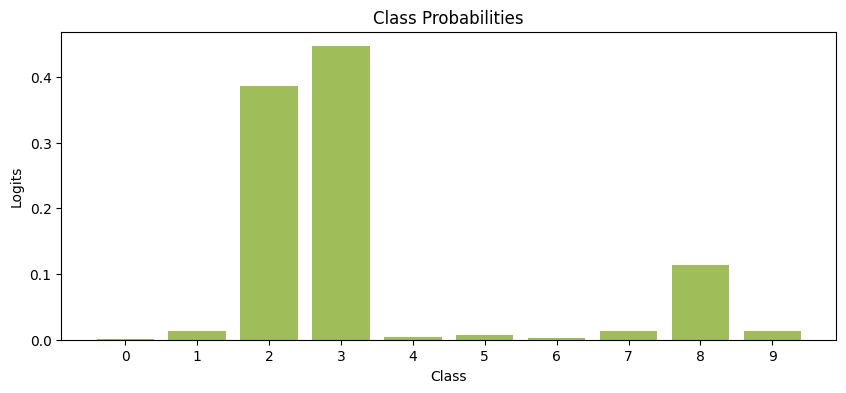

In [ ]:
i = 28
with torch.no_grad():
    logits = model(images[i].unsqueeze(0).to(device))
plt.imshow(images[i].reshape(28, 28), cmap="gray")
plt.title(f"Predicted: {logits.argmax().item()}, Actual: {labels[i]}")
plt.axis("off")

heat = True

c = abs(1 / logits.sum()) if heat else 1
probabilities = ((logits - logits.max()) * c).softmax(dim=1)[0]
plt.figure(figsize=(10, 4))
plt.bar(range(10), probabilities.cpu().numpy(), color="#9fbd59")
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Logits")
plt.title("Class Probabilities")
plt.show()

In [ ]:
torch.save(model.state_dict(), "cnn_model.pth")

In [ ]:
model.load_state_dict(torch.load("cnn_model.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
sum(torch.numel(p) for p in nn.Conv2d(32, 32, 2, 3).parameters())